In [1]:
import os 
import re
import random
import pandas as pd
import numpy as np


import cv2 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model,optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout,Embedding,Add
from tqdm import tqdm
from pickle import load,dump
from sklearn.feature_extraction.text import CountVectorizer

from utils import  Image_Caption,get_tier

In [2]:
with open('model/word2index.pkl', 'rb') as pickle_file:
    word_index_Mapping = load(pickle_file)

word_index_Mapping['init'] = len(word_index_Mapping) + 1
index_word_Mapping = dict(map(reversed,word_index_Mapping.items()))
vocab_size = len(word_index_Mapping) + 1
print(vocab_size)

2966


In [3]:
max_caption_length = 84

In [4]:
%%time
#word embedding
glove_dir='glove/glove.6B.300d.txt'
embeddings_index = {}
embeddings_index_all = {}
f = open(glove_dir,encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index_all[word] = coefs
    if word in word_index_Mapping.keys():
        embeddings_index[word] = coefs

f.close()    


CPU times: total: 16.3 s
Wall time: 27.7 s


In [5]:
%%time
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size,embedding_dim))

for word, i in word_index_Mapping.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CPU times: total: 0 ns
Wall time: 8.62 ms


In [6]:
def get_model():
    image_input = Input(shape=(2048,))
    x = Dropout(0.4)(image_input)
    image_encode = Dense(256,activation='relu')(x)

    text_input = Input(shape=(max_caption_length,))
    x = Embedding(vocab_size,embedding_dim,mask_zero=True)(text_input)
    x = Dropout(0.4)(x)
    text_encode = LSTM(256)(x)

    decoder_input = Add()([image_encode,text_encode])
    x = Dense(256,activation='relu')(decoder_input)
    output = Dense(vocab_size,activation='softmax')(x)
    model = Model(inputs=[image_input,text_input],outputs=output)


    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer)

    return model

In [7]:
model_path = 'model/model.h5'
model = get_model()
model.load_weights(model_path)

In [8]:
femodel = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')
incp_model_feature = Model(femodel.input,femodel.layers[-2].output)

In [9]:
im_cp = Image_Caption(images_dir='',
                      model = model,
                      fe_model=incp_model_feature,
                      w2v = embeddings_index_all,
                      tier = get_tier('tier1.txt'),
                      word_index_Mapping=word_index_Mapping,
                      index_word_Mapping=index_word_Mapping,
                      max_caption_length=max_caption_length,
                      vocab_size=vocab_size
)


0.
Time passed: 1.7195611000061035
13 indian 50 black show america 50 written show america 50 written show america 50 written show

Best score-> books and literature:	58.001


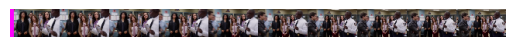

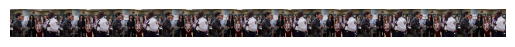


29.
Time passed: 0.18107867240905762
many indian 50 written show america written show item streets indian forehead ocean 50 bucking

Best score-> books and literature:	57.535


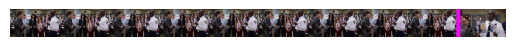

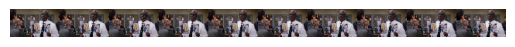

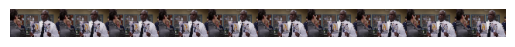

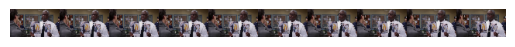

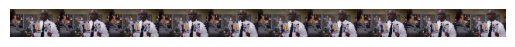

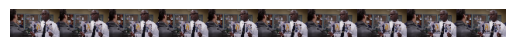

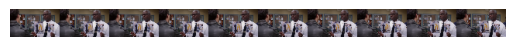

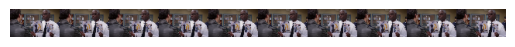

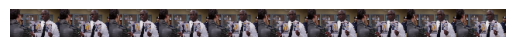

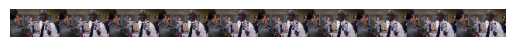

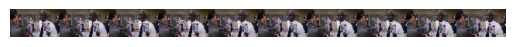

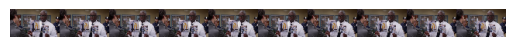

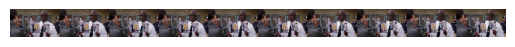

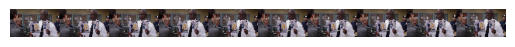

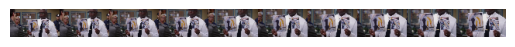

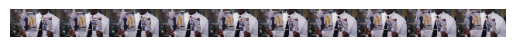

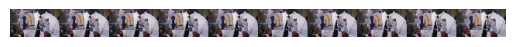


192.
Time passed: 0.14373087882995605
many item women 50 bikes show america written show item streets indian forehead ocean 50 bucking

Best score-> personal celebrations & life events:	58.34


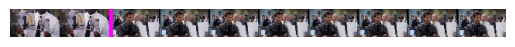

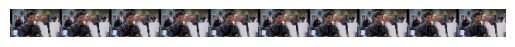

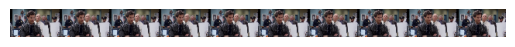

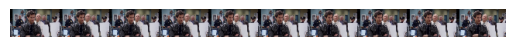

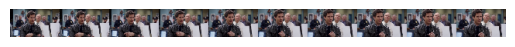


248.
Time passed: 0.15256381034851074
many item holiday 50 13 indian 50 written show america written show item streets indian forehead ocean 50 bucking

Best score-> personal celebrations & life events:	58.653


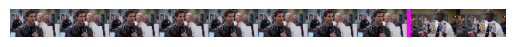

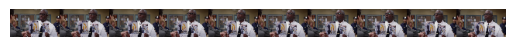

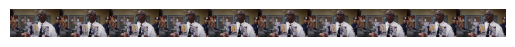

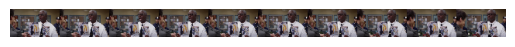


282.
Time passed: 0.20317935943603516
many item women 50 belly america written show item streets indian forehead ocean 50 many

Best score-> books and literature:	57.278


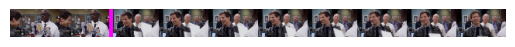

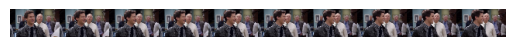

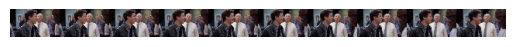


320.
Time passed: 0.13585162162780762
13 indian 50 black show item streets olympics 50 skate

Best score-> personal celebrations & life events:	56.555


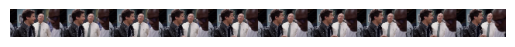

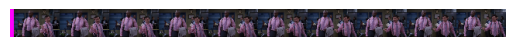

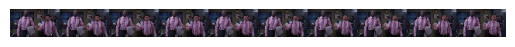


348.
Time passed: 0.19155550003051758
13 indian 50 black show america 50 written show item streets olympics 50 skate

Best score-> personal celebrations & life events:	60.436


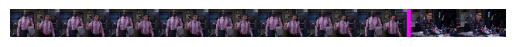

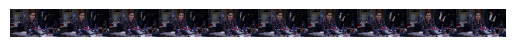

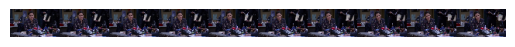

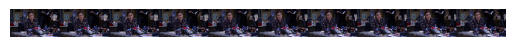


383.
Time passed: 0.16477537155151367
13 indian 50 black show item streets olympics 50 breakdancing bucking

Best score-> personal celebrations & life events:	52.493


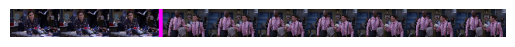

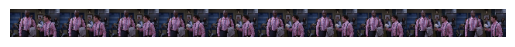

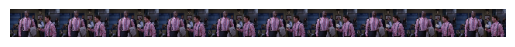

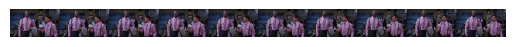

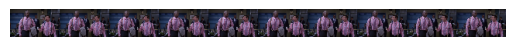

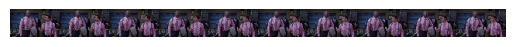

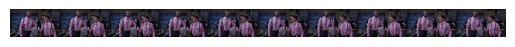

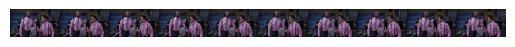

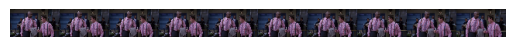

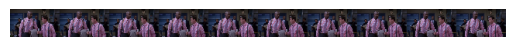

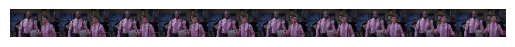

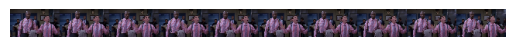

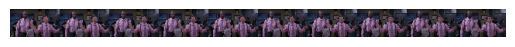

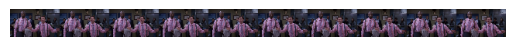

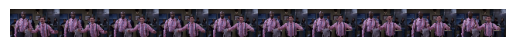

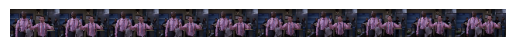

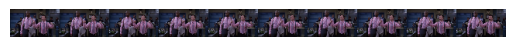

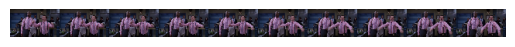

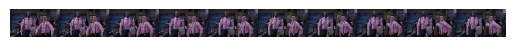

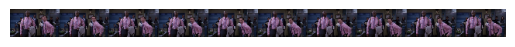

In [10]:
im_cp.caption_video('sample.mp4')